<a href="https://colab.research.google.com/github/kiharalab/DeepMainMast/blob/main/DeepMainMast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepMainMast


<img src="https://github.com/kiharalab/DeepMainMast/blob/main/DeepMainMast_Logo.png?raw=1" height=380 width=300/>

**License**: GPL v3 for academic use. (For commercial use, please contact us for different licensing)

**Contact**: Daisuke Kihara (dkihara@purdue.edu)

**Cite this work**: "Integrated Protocol of Protein Structure Modeling for cryo-EM with Deep Learning and Structure Prediction, Genki Terashi, Xiao Wang, Devashish Prasad, Tsukasa Nakamura and Daisuke Kihara, Nature Methods (2023)"

# Run DeepMainMast pipeline (7 steps)

1. <u>Install dependencies</u>: Install libraries and download the models/scripts
2. <u>Input files </u>: Upload the cryo-em map file (.map and or .mrc), Sequence file (.fasta) and Alphafold file (.pdb)
3. <u>Configure parameters</u>: Emap Countour level, Number of seconds limit and Number of final models
4. <u>Execute DeepMainMast</u>: Execute the DeepMainMast pipeline sequentially with the specified configuration and input.
5. <u> Visualize pre rosetta </u>: Visualize Ca path tracing model.


Please make sure the notebook is already connected to **GPU**, DeepMainMast needs GPU support to run.<br>
Click the right top button **"connect"**, then the notebook will automatically connect to a gpu machine.

### Note for free account users
If you have a free account, you can use one session for a maximum of 4 hours. But please note that if your sequence has over 600 residues, the DeepMainmast process on Google Colab may take longer than 4 hours. Also, for big structure with more than 2,000 residues, the memory in the colab of 12GB is not enough to support. Also, limited by CPU power, here we run a faster version with less parameter search for backbone tracing and sequence assignment optimization steps. <b>For those cases, please use our server [https://em.kiharalab.org/algorithm/DeepMainMast](https://em.kiharalab.org/algorithm/DeepMainMast).</b>


### DeepMainMast is also available at

Server (Recommended):
- [https://em.kiharalab.org/algorithm/DeepMainMast](https://em.kiharalab.org/algorithm/DeepMainMast)

Code Ocean Capsule:
- [https://codeocean.com/capsule/0749800](https://codeocean.com/capsule/0749800) (Limited by redistribution constraints, only Ca tracing is available here)

Colab Notebooks:
- [https://colab.research.google.com/github/kiharalab/DeepMainMast/blob/main/DeepMainMast.ipynb](https://colab.research.google.com/github/kiharalab/DeepMainMast/blob/main/DeepMainMast.ipynb) <-- current notebook (Limited by redistribution constraints, only Ca tracing is available here)

Github:
- [DeepMainMast Repo](https://github.com/kiharalab/DeepMainMast)



In [ ]:
#@title 1. Install dependencies <a name="Dependency"></a>
#@markdown We will download github repo and some large binary files. Then we will install dependencies using pip. And then we will download and compile some libraries using GCC compiler<br><br>
#@markdown This cell may take about 5 mins to run

print("Downloading the github repo ... ")
# Download git directory with source code
!git clone --quiet https://github.com/kiharalab/DeepMainMast.git &>> /content/output


print("Installing python dependencies ... ")
# Install python dependencies using pip
!pip install -r /content/DeepMainMast/requirements.txt &>> /content/output
print("Done installing python dependencies\n")

# Install fftw library
print("Installing the fftw library\n")
!apt-get -qq install -y libfftw3-3 libfftw3-dev libfftw3-doc &>> /content/output
print("Done installing the fftw library\n")

print("Installing gcc dependencies ... ")
%cd /content/DeepMainMast/
!bash make_c_programs.sh


Installing python dependencies ... 
Done installing python dependencies

Installing the fftw library

Done installing the fftw library

Installing gcc dependencies ... 
/content/DeepMainMast
/content/DeepMainMast/src /content/DeepMainMast
/content/DeepMainMast/src/VESPER_Power_src /content/DeepMainMast/src /content/DeepMainMast
find . -name "*.o" -type f -delete
gcc -O3 -c chkcmdline.c
gcc -O3 -c mrc.c -lm -O3 -msse4.2 -msse -msse2 -msse3 -mmmx -ftree-vectorize -ftree-vectorizer-verbose=3 -ffast-math -march=native -funroll-loops -fopenmp
gcc -O3 -c readpdb.c -lm -O3 -msse4.2 -msse -msse2 -msse3 -mmmx -ftree-vectorize -ftree-vectorizer-verbose=3 -ffast-math -march=native -funroll-loops -fopenmp
gcc -O3 -c mrcfft.c -lm -O3 -msse4.2 -msse -msse2 -msse3 -mmmx -ftree-vectorize -ftree-vectorizer-verbose=3 -ffast-math -march=native -funroll-loops -fopenmp -lfftw3_threads -lfftw3f
gcc -o VESPER_Power main.c chkcmdline.o mrc.o readpdb.o mrcfft.o -lm -O3 -msse4.2 -msse -msse2 -msse3 -mmmx -ftree

In [ ]:
#@title 2. Input Files

#@markdown You need to upload a cryo-EM map file (.mrc or .map), sequence file (.fasta) and optional Alphafold file (.pdb).

#@markdown You can tick the below checkbox to use a default input files as an example <br> Otherwise, please untick the checkbox and run the subsequent cells to upload your files.

#@markdown Lastly, also provide a job name for running this job with the specified input.

use_author_example = False #@param {type:"boolean"}
job_name = "author_example_2513" #@param {type:"string"}

if use_author_example:
  job_name = "2513"
  use_AF_Model = True

In [ ]:
#@title 2.1 Input EM map file

#@markdown <br> **Support file format: .map and/or .mrc**

from google.colab import files
import os
import os.path
import re
import hashlib
import random
import string

input_map = ""

if not use_author_example:
  upload_dir = f"/content/DeepMainMast/data/{job_name}"
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  #os.chdir(upload_dir)
  map_input = files.upload()
  for fn in map_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(map_input[fn])))
    input_map = os.path.abspath(fn)
    print("Map saved in %s"%upload_dir)
  map_path = upload_dir + "/input.map"
  !mv $input_map $map_path
else:
  print("you have chosen to use author's example, you can not upload map files any more.")
  map_path="/content/DeepMainMast/data/2513/emd_2513.mrc"

you have chosen to use author's example, you can not upload map files any more.


In [ ]:
#@title 2.2 Input Seq.fasta file <a name="Map"></a>

#@markdown <br> **Support file format: .fasta**

from google.colab import files
import os
import os.path
import re
import hashlib
import string

seq_file = ""

if not use_author_example:
  upload_dir = f"/content/DeepMainMast/data/{job_name}"
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  #os.chdir(upload_dir)
  map_input = files.upload()
  for fn in map_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(map_input[fn])))
    seq_file = os.path.abspath(fn)
    print("Map saved in %s"%upload_dir)
  seq_path = upload_dir + "/seq.fasta"
  !mv $seq_file $seq_path
else:
  print("you have chosen to use author's example, you can not upload map files any more.")
  seq_path="/content/DeepMainMast/data/2513/emd_2513.fasta"

you have chosen to use author's example, you can not upload map files any more.


In [ ]:
#@title 2.3 Input Alphafold model [Optional]

#@markdown Please tick the below checkbox and run the cell to upload your alphafold .pdb file. Otherwise, please untick the checkbox and run this cell to make deepmainmast pipeline proceed without any alphafold model. <br>
#@markdown  Please combine all single-chain structures in one PDB file, separated by "TER" for different chains' records. The chain ID does not matter, for identical chains, you only need to provide the chain records once in the pdb format.

use_AF_Model = True #@param {type:"boolean"}

#@markdown <br> **Support file format: .pdb**

af_model_file = ""

if use_AF_Model and not use_author_example:
  upload_dir = f"/content/DeepMainMast/data/{job_name}/"
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  #os.chdir(upload_dir)
  map_input = files.upload()
  for fn in map_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(map_input[fn])))
    af_model_file = os.path.abspath(fn)

    print("Map saved in %s"%upload_dir)
  af_path=upload_dir+"/af2_model.pdb"
  !mv $af_model_file $af_path
elif not use_AF_Model:
  print("You have chosen not to upload .pdb files for alphafold.")
else:
  print("You have chosen to use author's example, you can not upload .pdb files any more.")
  af_path="/content/DeepMainMast/data/2513/emd_2513_af2.pdb"
  use_AF_Model=True
if use_AF_Model == True:
  use_AF_Model = 1

You have chosen to use author's example, you can not upload .pdb files any more.


In [ ]:
#@title 3 Configure parameters
#@markdown <br> 1. Specify the recommended contour level for your map in contour_level variable.
#@markdown If your recommended contour level is 2.5 then enter 2.5 in the input filed below
contour_level = 0.01 #@param {type:"number"}

#@markdown <br> 2. Some steps in DeepMainMast take a lot of time to compute. You can specify the number of seconds to be used per iteration for these compute heavy steps using num_seconds variable. If you keep value num_seconds to be very low then sometimes DeepMainMast might not work correctly. It is recommended to start with num_seconds=600 for your new map. Suggested time: [total_num_residues].
num_seconds = 600 #@param {type:"number"}


#@markdown <br> 3. Select it if you have two or more identical chains in your structure.
homo = False #@param {type:"boolean"}

if homo == True:
  homo = 1
else:
  homo = 0

In [ ]:
#@title 4. Run DeepMainMast

%cd /content/DeepMainMast

!chmod 777 *
!chmod -R 777 /content/DeepMainMast/

print("Running DeepMainMast ...")

command_line="./dmm_full_multithreads.sh -p ./ -m %s -f %s -c %f -o prediction -t %d -T %d -C 2 -M 2 -F "%(map_path,seq_path,contour_level,num_seconds,num_seconds)
if homo:
  command_line+=" -H "
if use_AF_Model:
  command_line+=" -A %s "%af_path
command_line+=" &>> /content/output"
print(command_line)
!$command_line
print("Done running DeepMainMast\n")

/content/DeepMainMast
Running DeepMainMast ...
./dmm_fast_multithreads.sh -p ./ -m /content/DeepMainMast/data/2513/emd_2513.mrc -f /content/DeepMainMast/data/2513/emd_2513.fasta -c 0.010000 -o prediction -t 600 -T 600 -C 8 -M 8  -A /content/DeepMainMast/data/2513/emd_2513_af2.pdb  &>> /content/output
Done running DeepMainMast



In [ ]:
#@title 5. Download Output <a name="Download"></a>
#@markdown After scoring and ranking step execution is complete you can download the final predicted structure (.pdb files) of your input map under /content/DeepMainMast/prediction/DeepMainmast.pdb.
#@markdown This file contains MODEL1 and MODEL2.<br>
#@markdown In MODEL1, the b-factor column in modeled positions represents DAQ(AA) score using a 19-residue sliding window.<br>
#@markdown  In MODEL2, amino acids with a DAQ(CA) score below -0.5 are excluded, and those at locations with a DAQ(AA) score below -0.5 are replaced with “UNK.”
#@markdown <b>In pymol, visualize with the following command</b><br> ```spectrum b, red_white_blue,  all, -1,1```
#@markdown <br>blue indicates good regions, while the red indicates possibly wrong regions.
from google.colab import files
pdb_file="/content/DeepMainMast/prediction/DeepMainmast.pdb"
files.download(pdb_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

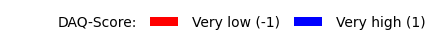

In [ ]:
#@title 6. Visualization
#@markdown 3dmol can not visualize Calpha tracing well. Please download to check the connections in Pymol. You can also try our server for better online visualization: https://em.kiharalab.org/algorithm/DeepMainMast
!pip install py3Dmol==2.0.0.post2 &>> /content/output
!pip install nglview &>> /content/output
pdb_file="/content/DeepMainMast/prediction/DeepMainmast.pdb"
import py3Dmol

import matplotlib.pyplot as plt

def plot_plddt_legend():
  thresh = ['DAQ-Score:','Very low (-1)','Very high (1)']
  plt.figure(figsize=(1,0.1),dpi=100)
  ########################################
  for c in ["#FFFFFF","#FF0000","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt
#exit()
#Visualize
import py3Dmol
def show_pdb(output_pdb_path):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(output_pdb_path,'r').read(),'pdb')
  BB = ['CA']
  view.setStyle({'sphere': {'colorscheme': {'prop':'b','gradient':'rwb','min':-1,'max':1}}})
  #view.setStyle({'cartoon': {'color':'spectrumb'}})
  #view.setStyle({'cartoon': {'spectrum': {'prop':'b','min':-1,'max':1}}})
  view.zoomTo()
  return view
show_pdb(pdb_file).show()
plot_plddt_legend().show()
